# Time Dependent method

In [2]:
#Importing the libraries to watch the 'fits' image and get the data array
import astropy
import plotly.graph_objects as go
from astropy.io import fits
#Importing a library that is useful to read the original file
import pandas as pd
import pylab as plb
import matplotlib.pyplot as plt
from scipy.stats import chisquare

from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
#Importing a visual library with some illustrative set up
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
from matplotlib import cm
import numpy as np
import math 
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import signal
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (16, 8) 
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
plt.rcParams["axes.grid"] = True
#plt.rcParams['']
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256))) 
bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

In [3]:
data=pd.read_csv('data.csv',sep=';')
data=data.rename(columns={'Data':'Day','Godzina':'hour','Minuty':'minutes','Wolumen':'Load'})
data['seconds']=np.arange(0,len(data)*900,900)
detrended_sig=signal.detrend(data.Load)
sig=detrended_sig*np.hanning(len(detrended_sig))

In [4]:
load_no_line=signal.detrend(data.Load,type='linear')
clean_load=np.array(load_no_line)-np.array(load_no_line).mean()
data['clean_load']=clean_load
data=data.drop(columns=['Load']).rename(columns={'clean_load':'Load'})

In [5]:
#Mean FFT on Training set 

data.Day=pd.to_datetime(data.Day)
data['Year']=data.Day.dt.year #Years
data['Month']=data.Day.dt.month #Months
YEARS=np.sort(list(set(data.Year.tolist()))).tolist() #Year list
load_yf=0
for y in range(len(YEARS)-2): #len of the training set
    df_year=data[data['Year']==YEARS[y]]
    if y==0 or y==4: #leap years :) 
        df_year=df_year.drop(df_year[df_year.Day==(str(YEARS[y])+'-02-29')].index)
    load_yf=load_yf+np.fft.fft(df_year.Load)
four_year=load_yf/(len(YEARS)-2)

Text(0.5, 1.0, 'Mean Fourier Spectrum')

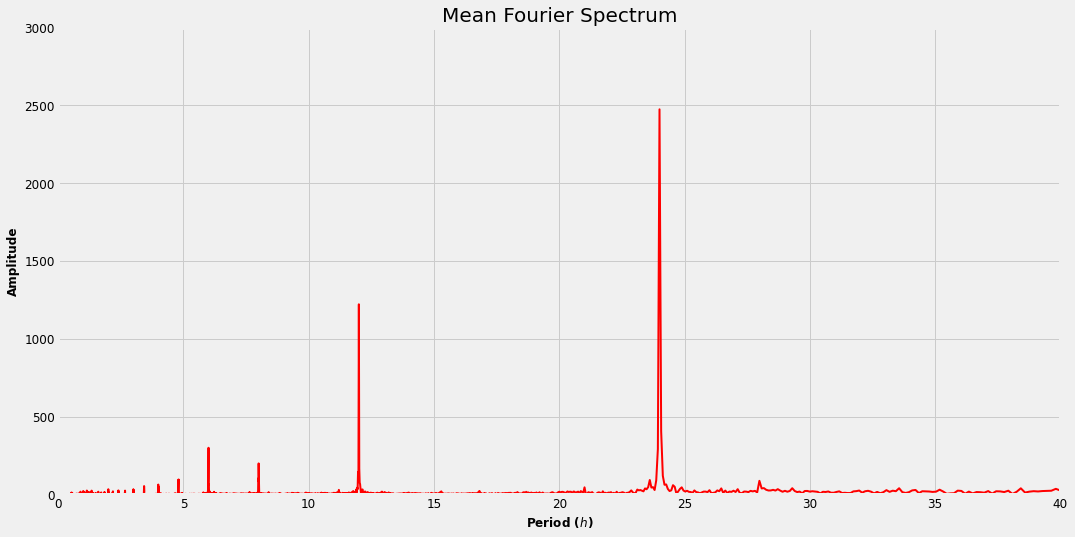

In [6]:
#Fourier transform is defined on the frequency axis. 
#In order to make it more visible, the conversion on the period has been applied
new_N=int(len(four_year)/2) 
f_nat=1/900
new_X = np.linspace(10**-12, f_nat/2, new_N, endpoint=True)
new_Xph=1.0/(new_X*60*60)
plt.xlim(0,40)
plt.plot(new_Xph,np.abs(2*four_year[:int(len(four_year)/2.)]/len(four_year)),color='red')
plt.ylabel('Amplitude')
plt.xlabel('Period ($h$)')
plt.ylim(0,3000)
plt.title('Mean Fourier Spectrum',fontsize=20)

In [7]:
#Validation 
TH=np.arange(0.01,0.5,0.01) #threshold Values
opt_t=[] #Threshold values that are acceptable in terms of RMSE and Correlation values 
opt_corr=[] #Acceptable Correlation values
abs_year=np.array(abs(four_year))
for t in TH:
    t_abs_year=abs_year.copy()
    t_abs_year[t_abs_year<(t*t_abs_year.max())]=0 #Apply the threshold on the absolute value 
    t_four_year=four_year.copy() 
    t_four_year[t_abs_year==0]=0 #Apply the threshold on Fourier transform
    RMSE=np.sqrt(mean_squared_error(np.fft.ifft(t_four_year).real,data[data.Year==2015].Load)) #inverse transform and compute RMSE
    if RMSE<2000: #First requirement: LOW RMSE 
        new_TH=np.arange(t*0.1,t,t*0.1) #More specific threshold 
        for t_new in new_TH:
            t_new_abs_year=abs_year.copy()
            t_new_abs_year[t_new_abs_year<(t_new*t_new_abs_year.max())]=0
            t_new_four_year=four_year.copy()
            t_new_four_year[t_new_abs_year==0]=0
            E=np.fft.ifft(t_new_four_year).real-df_year.Load
            corr=pd.DataFrame({'A':df_year.Load,'B':E}).corr().values[0][1]
            if abs(corr)<=0.54: #Second requirement: LOW CORRELATION
                opt_t.append(t_new)
                opt_corr.append(corr)
opt_corr=np.abs(opt_corr)

In [8]:
#Selecting the best reconstruction 
best_th=opt_t[opt_corr.argmin()] #Best threshold value 
abs_year=np.array(abs(four_year))
t_abs_year=abs_year.copy()
t_abs_year[t_abs_year<(best_th*t_abs_year.max())]=0
med_four=four_year.copy()
med_four[t_abs_year==0]=0 #Best fourier transform

In [9]:
RMSEs=[]
test=data[data['Year']==2016] #Test year 
test=test.drop(test[test.Day==('2016-02-29')].index) #Again, leap year
C=[] #Correlation list 
TIME=np.arange(0,100,10) #Timestep we want to check
rmse_four=np.fft.ifft(med_four) #Take our prediction
test=np.array(test.Load)

for t in range(len(TIME)-1):
    Rmse_test=test[96*(TIME[0]):96*(TIME[t+1])] #Take the load between two timestep
    Rmse_four=rmse_four[96*(TIME[0]):(96*(TIME[t+1]))] #Take the prediction between the same timestep 
    RMSEs.append(np.sqrt(mean_squared_error(Rmse_four.real,Rmse_test))) #Compute the RMSE 
    C.append(np.corrcoef(Rmse_four.real-Rmse_test,Rmse_test)[0][1]) #Compute the correlation 
res_data=pd.DataFrame({'RMSE':RMSEs, 'Days':TIME[1:], '$C_{data,error}$': C}) #Store them in a dataframe
res_data #Et voilà

,RMSE,Days,"$C_{data,error}$"
0,1693.695791,10,-0.499368
1,1653.856232,20,-0.585153
2,1624.499448,30,-0.551421
3,1750.290004,40,-0.572128
4,1705.301569,50,-0.576848
5,1743.120579,60,-0.582676
6,1739.518557,70,-0.587305
7,1758.083806,80,-0.591095
8,1945.835666,90,-0.621008


In [11]:
print('Percentage of the maximum: '+ str(100*np.array(RMSEs).min()/data.Load.max())+ '%')

Percentage of the maximum: 20.46882449786972%


/Users/pierohmd/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


([<matplotlib.axis.XTick at 0x7f8d067bdbb0>,
 [Text(0, 0, '0'),
  Text(96, 0, '1'),
  Text(192, 0, '2'),
  Text(288, 0, '3'),
  Text(384, 0, '4'),
  Text(480, 0, '5'),
  Text(576, 0, '6'),
  Text(672, 0, '7'),
  Text(768, 0, '8'),
  Text(864, 0, '9'),
  Text(960, 0, '10'),
  Text(1056, 0, '11'),
  Text(1152, 0, '12'),
  Text(1248, 0, '13'),
  Text(1344, 0, '14'),
  Text(1440, 0, '15'),
  Text(1536, 0, '16'),
  Text(1632, 0, '17'),
  Text(1728, 0, '18'),
  Text(1824, 0, '19'),
  Text(1920, 0, '20'),
  Text(2016, 0, '21'),
  Text(2112, 0, '22'),
  Text(2208, 0, '23'),
  Text(2304, 0, '24'),
  Text(2400, 0, '25'),
  Text(2496, 0, '26'),
  Text(2592, 0, '27'),
  Text(2688, 0, '28'),
  Text(2784, 0, '29')])

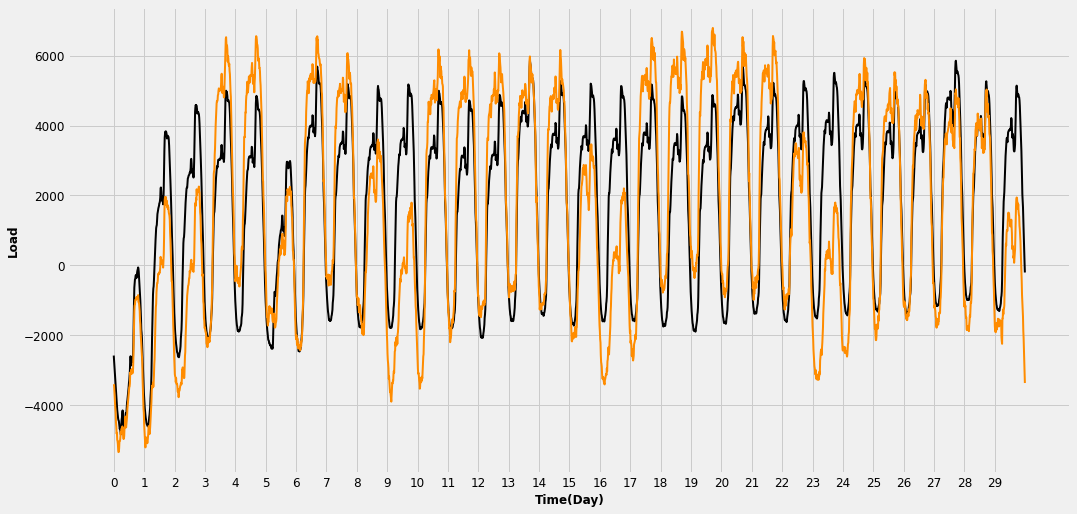

In [17]:
plt.plot(rmse_four[0:30*96],color='k')
plt.plot(test[0:30*96],color='darkorange')
plt.xlabel('Time(Day)')
plt.ylabel('Load')
plt.xticks(np.arange(0,30*96,96),np.arange(0,30))